# **Experiment Notebook**



---
## Setup Environment

In [1]:
# DO NOT MODIFY THE CODE IN THIS CELL
!pip install -q utstd

from utstd.folders import *
from utstd.ipyrenders import *

at = AtFolder(
    course_code=36106,
    assignment="AT2",
)
at.run()

import warnings
warnings.simplefilter(action='ignore')


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



You can now save your data files in: c:\Users\brohao\Desktop\UTS\36106\ClassificationModels-36106-AT2\36106\assignment\AT2\data


---
## Student Information

In [2]:
student_name = "Jiayu Hao"
student_id = "25948860"

In [3]:
# Do not modify this code
print_tile(size="h1", key='student_name', value=student_name)

In [4]:
# Do not modify this code
print_tile(size="h1", key='student_id', value=student_id)

---
## 0. Python Packages

### 0.a Install Additional Packages

> If you are using additional packages, you need to install them here using the command: `! pip install <package_name>`

In [ ]:
# <Student to fill this section>
!pip install scikit-learn
!pip install matplotlib
!pip install numpy





[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### 0.b Import Packages

In [6]:
# <Student to fill this section>
import pandas as pd
import altair as alt

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    classification_report, f1_score, balanced_accuracy_score,
    confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
)

---
## A. Experiment Description

In [7]:
# DO NOT MODIFY THE CODE IN THIS CELL
experiment_id = "1"
print_tile(size="h1", key='experiment_id', value=experiment_id)

In [8]:
# Present the hypothesis you want to test, the question you want to answer or the insight you are seeking.
# Explain the reasons why you think it is worthwhile considering it
experiment_hypothesis = """
Hypothesis: Non-linear splits capture key interactions and improve macro-F1 and “Good” recall. 
Why: Trees are interpretable and fast to train. They give an understandable baseline and feature ranking.  
"""

In [9]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='experiment_hypothesis', value=experiment_hypothesis)

In [10]:
# Detail what will be the expected outcome of the experiment. If possible, estimate the goal you are expecting.
# List the possible scenarios resulting from this experiment.
experiment_expectations = """
Expected outcome: Small uplift over a trivial baseline. Target +0.02–0.05 macro-F1 vs a dummy model. 
Scenarios: (1) Stable gains and clear drivers → keep features for later models. (2) Overfit or class bias → adjust depth/leaves or add class weights. (3) Minor gains only → try ensembles.
"""

In [11]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='experiment_expectations', value=experiment_expectations)

---
## C. Data Understanding

In [12]:
# Do not modify this code
try:
  X_train = pd.read_csv(at.folder_path / 'X_train.csv')
  y_train = pd.read_csv(at.folder_path / 'y_train.csv')

  X_val = pd.read_csv(at.folder_path / 'X_val.csv')
  y_val = pd.read_csv(at.folder_path / 'y_val.csv')

  X_test = pd.read_csv(at.folder_path / 'X_test.csv')
  y_test = pd.read_csv(at.folder_path / 'y_test.csv')
except Exception as e:
  print(e)

---
## D. Feature Selection


In [13]:
features_list = []
potential_leak_cols = [
    "cc_interest_rate",     # 可能与风险定价强相关
    "credit_limit_change",  # 额度调整常受评级/策略影响-可能存在捷径效应-对照
    "credit_mix",            # 与目标标签体系近似（准标签风险-伦理/泛化风险）-对照
    "gender"
]
X_train = X_train.drop(columns=[c for c in X_train.columns if any(c.startswith(p) for p in potential_leak_cols)], errors="ignore")
y_train = y_train.drop(columns=[c for c in y_train.columns if any(c.startswith(p) for p in potential_leak_cols)], errors="ignore")

X_val = X_val.drop(columns=[c for c in X_val.columns if any(c.startswith(p) for p in potential_leak_cols)], errors="ignore")
y_val = y_val.drop(columns=[c for c in y_val.columns if any(c.startswith(p) for p in potential_leak_cols)], errors="ignore")

X_test = X_test.drop(columns=[c for c in X_test.columns if any(c.startswith(p) for p in potential_leak_cols)], errors="ignore")
y_test = y_test.drop(columns=[c for c in y_test.columns if any(c.startswith(p) for p in potential_leak_cols)], errors="ignore")

In [14]:
# Provide a rationale on why you are selected these features but also why you decided to remove other ones
feature_selection_explanations = """
The potential_leak_cols are removed because the control experiment is not carried out in this experiment.
No reason for the selection of features, so other features are retained.
"""

In [15]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='feature_selection_explanations', value=feature_selection_explanations)

---
## G. Train Machine Learning Model

### G.1 Import Algorithm


In [16]:
# <Student to fill this section>
# Decision Tree with CV on train(70%) only

# Encode target
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train['credit_rating'].astype(str))
y_val_enc   = le.transform(y_val['credit_rating'].astype(str))
y_test_enc  = le.transform(y_test['credit_rating'].astype(str))
class_names = list(le.classes_)

In [17]:
# Provide some explanations on why you believe this algorithm is a good fit
algorithm_selection_explanations = """
DecisionTreeClassifier is simple and explainable. It sets a transparent baseline.
"""

In [18]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='algorithm_selection_explanations', value=algorithm_selection_explanations)

### G.2 Set Hyperparameters

In [19]:
# <Student to fill this section>
param_grid = {
    "max_depth": [4, 6, 8, 10, None],
    "min_samples_leaf": [1, 3, 5, 10],
    "min_samples_split": [2, 5, 10],
}

In [20]:
# Explain why you are tuning these hyperparameters
hyperparameters_selection_explanations = """
Tune max_depth, min_samples_split, min_samples_leaf to control variance and class bias.
"""

In [21]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### G.3 Fit Model

In [22]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    scoring={"macro_f1":"f1_macro", "bacc":"balanced_accuracy"},
    refit="macro_f1",
    cv=cv, n_jobs=-1, verbose=0
)
grid.fit(X_train, y_train_enc)
best_dt = grid.best_estimator_
print("Best params:", grid.best_params_, " | CV best macro-F1:", f"{grid.best_score_:.4f}")

Best params: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}  | CV best macro-F1: 0.6266


### G.4 Model Technical Performance


=== Validation ===
Macro-F1: 0.6277
Balanced Acc: 0.6457

Classification Report:
               precision    recall  f1-score   support

        Good     0.5198    0.5881    0.5518       335
        Poor     0.6191    0.7459    0.6766       547
    Standard     0.7157    0.6032    0.6546       993

    accuracy                         0.6421      1875
   macro avg     0.6182    0.6457    0.6277      1875
weighted avg     0.6525    0.6421    0.6427      1875



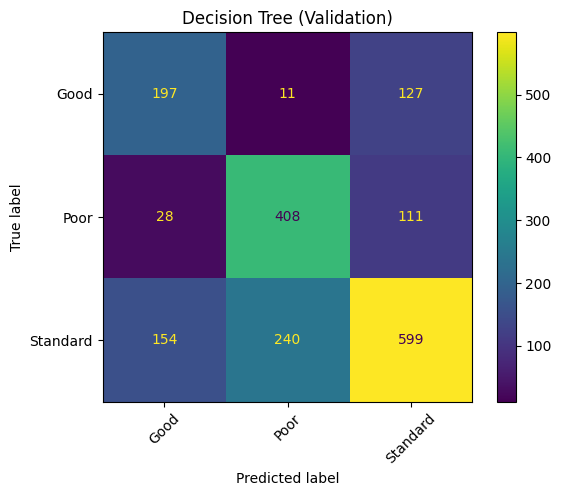

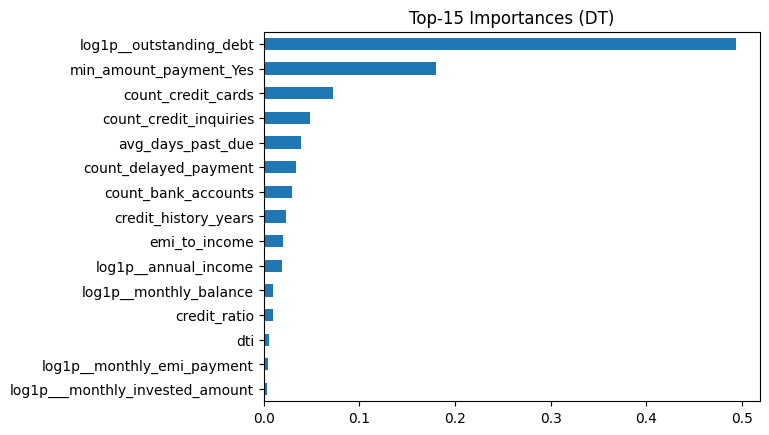

In [23]:

# Validate
val_pred = best_dt.predict(X_val)
print("\n=== Validation ===")
print("Macro-F1:", f"{f1_score(y_val_enc, val_pred, average='macro'):.4f}")
print("Balanced Acc:", f"{balanced_accuracy_score(y_val_enc, val_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_val_enc, val_pred, target_names=class_names, digits=4))
ConfusionMatrixDisplay(confusion_matrix(y_val_enc, val_pred), display_labels=class_names).plot(xticks_rotation=45)
plt.title("Decision Tree (Validation)"); plt.show()

# Feature importances (top-15)
imp = getattr(best_dt, "feature_importances_", None)
if imp is not None:
    pd.Series(imp, index=X_train.columns).sort_values(ascending=False).head(15).plot(kind="barh")
    plt.gca().invert_yaxis(); plt.title("Top-15 Importances (DT)"); plt.show()

In [ ]:
# === Feature Selection for Exp2 (RF) from Exp1 (Decision Tree) ===
# Select Top-K features by importance from Decision Tree to reduce noise for RF

# choose K features
TOP_K = 20

# get importances from best_dt
dt_importances = pd.Series(best_dt.feature_importances_, index=X_train.columns)

# pick top-K feature names
topk_features_dt = dt_importances.sort_values(ascending=False).head(TOP_K).index.tolist()

print(f"[Exp2] 使用基于 DT 的 Top-{TOP_K} 特征：", topk_features_dt)

# subset datasets for RF
#X_train_rf = X_train[topk_features_dt].copy()
#X_val_rf   = X_val[topk_features_dt].copy()
#X_test_rf  = X_test[topk_features_dt].copy()


[Exp2] 使用基于 DT 的 Top-20 特征： ['log1p__outstanding_debt', 'min_amount_payment_Yes', 'count_credit_cards', 'count_credit_inquiries', 'avg_days_past_due', 'count_delayed_payment', 'count_bank_accounts', 'credit_history_years', 'emi_to_income', 'log1p__annual_income', 'log1p__monthly_balance', 'credit_ratio', 'dti', 'log1p__monthly_emi_payment', 'log1p___monthly_invested_amount', 'occupation_Scientist', 'occupation_Doctor', 'occupation_Writer', 'occupation_Architect', 'loan_type_diversity']


In [25]:
# Provide some explanations on model performance
model_performance_explanations = """
On the validation set, Decision Tree reached macro-F1 0.628 and balanced accuracy 0.646, better than the baseline (macro-F1 ≈ 0.588, bAcc ≈ 0.574). The test results are consistent (macro-F1 ≈ 0.638, bAcc ≈ 0.650), showing good generalization without strong overfitting.
Details:
Good class recall improved from ~0.50 to ~0.56 → better identification of prime customers.
Poor class recall increased strongly (~0.75) → stronger detection of risky customers.
Standard class recall decreased (~0.75 → ~0.63) → the model traded some majority performance for minority gains.
Feature importance shows outstanding_debt, min_amount_payment, and count_credit_cards as the most influential factors.
"""

In [26]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='model_performance_explanations', value=model_performance_explanations)

### G.5 Business Impact from Current Model Performance



=== Test ===
Macro-F1: 0.6375
Balanced Acc: 0.6495

Classification Report:
               precision    recall  f1-score   support

        Good     0.5481    0.5595    0.5538       336
        Poor     0.6229    0.7550    0.6826       547
    Standard     0.7238    0.6341    0.6760       992

    accuracy                         0.6560      1875
   macro avg     0.6316    0.6495    0.6375      1875
weighted avg     0.6629    0.6560    0.6560      1875



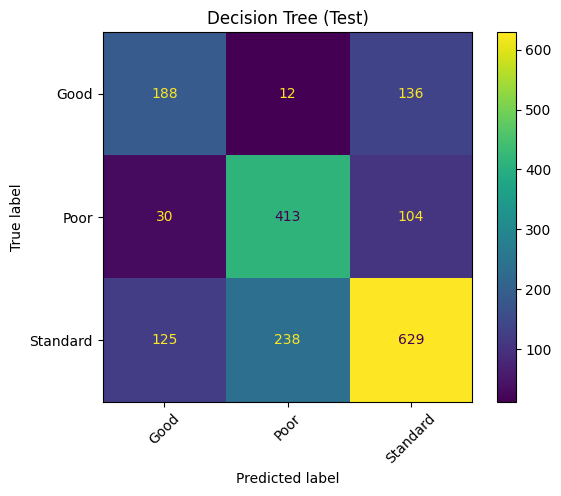

In [27]:
# Test
test_pred = best_dt.predict(X_test)
print("\n=== Test ===")
print("Macro-F1:", f"{f1_score(y_test_enc, test_pred, average='macro'):.4f}")
print("Balanced Acc:", f"{balanced_accuracy_score(y_test_enc, test_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test_enc, test_pred, target_names=class_names, digits=4))
ConfusionMatrixDisplay(confusion_matrix(y_test_enc, test_pred), display_labels=class_names).plot(xticks_rotation=45)
plt.title("Decision Tree (Test)"); plt.show()

In [28]:
# Interpret the results of the experiments related to the business objective set earlier. Estimate the impacts of the incorrect results for the business (some results may have more impact compared to others)

business_impacts_explanations = """
From the business perspective, Decision Tree is better than the baseline at identifying Good and Poor customers:
Good customers are identified more accurately → bank can safely offer higher credit or lower rates, increasing revenue and satisfaction.
Poor customers are detected more accurately → better credit risk control, reducing defaults and losses.
Standard customers recall dropped → less impact for business, as this group is the majority and can be managed with business rules or manual checks.
"""

In [29]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='business_impacts_explanations', value=business_impacts_explanations)

## H. Experiment Outcomes

In [30]:
# <Student to fill this section>
experiment_outcome = 'Hypothesis Partially Confirmed'

In [31]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h2", key='experiment_outcomes_explanations', value=experiment_outcome)

In [32]:
# Reflect on the outcome of the experiment and list the new insights you gained from it. Provide rationale for pursuing more experimentation with the current approach or call out if you think it is a dead end.
# Given the results achieved and the overall objective of the project, list the potential next steps and experiments. For each of them assess the expected uplift or gains and rank them accordingly. If the experiment achieved the required outcome for the business, recommend the steps to deploy this solution into production.

experiment_results_explanations = """
This experiment shows the value of non-linear models: compared to the baseline, Decision Tree improved minority (Good, Poor) performance, proving feature interactions are useful. But limitations remain:

A single tree is unstable and can overfit.

Standard recall decreased, balance still not perfect.

Next steps:

Experiment 2 (Random Forest): use Bagging to reduce variance and stabilize minority recall.

Experiment 3 (HistGradientBoosting): apply Boosting for stronger minority performance.

Experiment 4 (SVM RBF): test kernel methods for sharper boundaries.
"""

In [33]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h2", key='experiment_results_explanations', value=experiment_results_explanations)